In [2]:
import jax.numpy as jnp
import numpy as np
import os as os
import pylab as plt
import jax
import time

In [3]:
def rosenbrock(x): 
    x1, x2 = x
    return 100 * (x2 - x1 ** 2) ** 2 + (1 - x1) ** 2

In [ ]:
# Evolution Strategy Function (100+1 ES)
def es(objective_function, num_iterations, dimension, population_size, learning_rate):
    # Initialize population (100 candidates)
    population = np.random.randn(population_size, dimension)
    fitness = np.array([objective_function(ind) for ind in population])  # Fitness for all individuals
    best_solution = population[np.argmin(fitness)]
    best_fitness = np.min(fitness)
    
    trajectory = []

    for _ in range(num_iterations):
        # Generate offspring through mutation for each individual in the population
        offspring = population + learning_rate * np.random.randn(population_size, dimension)
        
        # Evaluate the objective function
        offspring_fitness = np.array([objective_function(ind) for ind in offspring])
        
        # Combine parents and offspring
        combined_population = np.vstack((population, offspring))
        combined_fitness = np.concatenate((fitness, offspring_fitness))
        
        # Select the best `population_size` individuals from the combined set
        best_indices = np.argsort(combined_fitness)[:population_size]
        population = combined_population[best_indices]
        fitness = combined_fitness[best_indices]
        
        # Track the best solution
        best_solution = population[0]
        best_fitness = fitness[0]
        
        # Store the best solution for analysis
        trajectory.append(best_solution.copy())

    return best_solution, trajectory

In [100]:
# Parameters for the ES
num_iterations = 100
dimension = 2
population_size = 100  # Population size (10)
learning_rate = 0.1

# Run NES three times and store the results
final_means = []
mean_trajectories = []

for i in range(3):
    final_mean, mean_trajectory = es(rosenbrock, num_iterations, dimension, population_size, learning_rate)
    final_means.append(final_mean)
    mean_trajectories.append(mean_trajectory)
    print(f"Run {i+1} - Optimal Parameters: {final_mean}")

Run 1 - Optimal Parameters: [0.99637879 0.9922363 ]
Run 2 - Optimal Parameters: [1.0009676  1.00206133]
Run 3 - Optimal Parameters: [1.00728107 1.01484893]


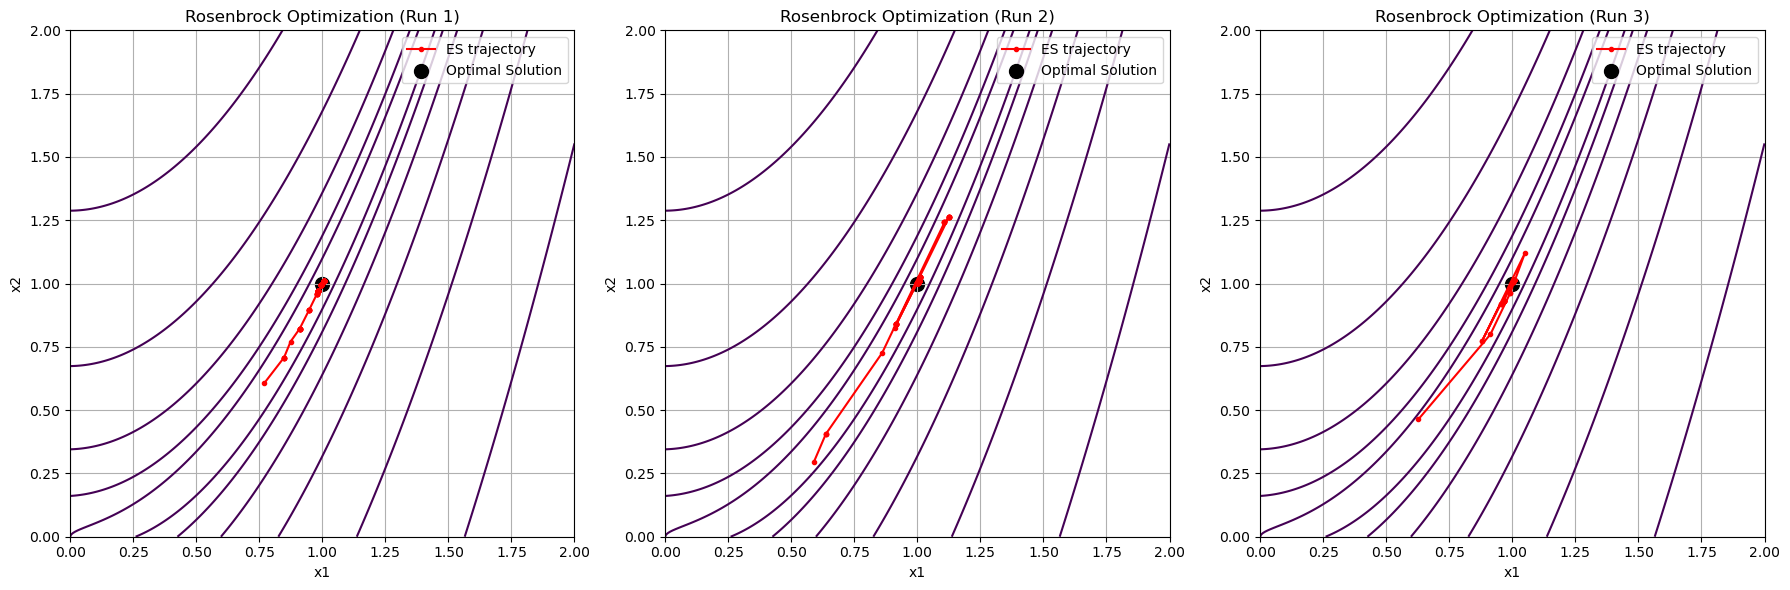

In [101]:
# Create a meshgrid for plotting the Rosenbrock function contour
x_vals = np.linspace(0, 2, 400)
y_vals = np.linspace(0, 2, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = rosenbrock(np.array([X, Y]))

# Set up the subplots for side-by-side plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, ax in enumerate(axes):
    # Plot the contour of the Rosenbrock function
    cp = ax.contour(X, Y, Z, levels=np.logspace(0, 5, 10), cmap='viridis')
    
    # Plot the trajectory of the best solutions from ES
    trajectory = np.array(mean_trajectories[i])
    ax.plot(trajectory[:, 0], trajectory[:, 1], color='r', marker='o', markersize=3, label="ES trajectory")

    # Highlight the optimal solution
    ax.scatter(1, 1, color='black', s=100, label="Optimal Solution")

    # Set titles, labels, and grid
    ax.set_title(f"Rosenbrock Optimization (Run {i+1})")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend()
    ax.grid()

# Adjust layout and add color bar
plt.tight_layout()
plt.show()

In [ ]:
x_vals = np.linspace(-2, 2, 400)
y_vals = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.array([[rosenbrock([x, y]) for x, y in zip(row_x, row_y)] for row_x, row_y in zip(X, Y)])

# Create the figure with 3 subplots (side by side)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# For each of the three iterations (or runs), plot the relevant mean trajectory and covariance
for i, ax in enumerate(axes):
    # Extract the mean and covariance for this iteration
    mean_trajectory = np.array(mean_trajectories[i])
    covariance_trajectory = np.array(covariance_trajectories[i])

    # Plot the contour of the Rosenbrock function
    ax.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap='viridis')

    # Plot the mean trajectory (orange path)
    ax.plot(mean_trajectory[:, 0], mean_trajectory[:, 1], marker='o', markersize=5, color='orange', label='Mean Path')

    # Highlight the optimal solution (1, 1)
    ax.scatter([1], [1], color='red', label='Optimal Solution (1, 1)', zorder=5)

    # Add the covariance ellipse at the current iteration
    for mu, cov in zip(mean_trajectory, covariance_trajectory):
        ellipse = plot_cov_ellipse(cov, mu, nstd=1, edgecolor='blue', alpha=0.3)
        ax.add_patch(ellipse)

    # Title and labels
    ax.set_title(f"Iteration {i + 1}")
    ax.set_xlabel("x-coordinate")
    ax.set_ylabel("y-coordinate")
    ax.grid()
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [80]:
def nes(objective_function, num_iterations, num_samples, dimension, learning_rate):
    # Initialize parameters
    mu = np.random.randn(dimension)  # Mean
    sigma = np.eye(dimension)  # Covariance matrix (identity)
    mean_trajectory = []
    covariance_trajectory = []
    
    for _ in range(num_iterations):
        # Sample from N(mu, sigma)
        z = np.random.multivariate_normal(mu, sigma, num_samples)

        # Evaluate the objective function
        fitness = np.array([objective_function(ind) for ind in z])
        
        # Rank fitness (lower is better) and normalize to calculate utilities
        ranked_indices = np.argsort(fitness)
        z = z[ranked_indices]

        # Calculate utility values for NES (rewards proportional to rank)
        utilities = np.arange(1, num_samples + 1)
        utilities = np.log(num_samples + 1) - np.log(utilities)
        utilities /= utilities.sum()  # Normalize utilities

        # Update mean
        # Calculate the gradient for the mean update
        mu_update = learning_rate * np.dot(utilities, z - mu)
        mu = mu + mu_update

        # Update covariance
        diff = z - mu
        sigma_update = learning_rate * np.sum(utilities[:, None, None] * (diff[:, :, None] @ diff[:, None, :] - sigma), axis = 0)
        sigma = sigma + 0.5 * sigma_update 

        if _ % 50 == 0:
            mean_trajectory.append(mu.copy())
            covariance_trajectory.append(sigma.copy())

    return mu, mean_trajectory, covariance_trajectory

In [81]:
# Parameters
num_iterations = 1000
num_samples = 100
dimension = 2         
learning_rate = 0.1 

# Run NES three times and store the results
final_means = []
mean_trajectories = []
covariance_trajectories = []

for i in range(3):
    final_mean, mean_trajectory, covariance_trajectory = nes(rosenbrock, num_iterations, num_samples, dimension, learning_rate)
    final_means.append(final_mean)
    mean_trajectories.append(mean_trajectory)
    covariance_trajectories.append(covariance_trajectory)
    print(f"Run {i+1} - Optimal Parameters: {final_mean}")

Run 1 - Optimal Parameters: [0.99999992 0.99999984]
Run 2 - Optimal Parameters: [0.99999997 0.99999995]
Run 3 - Optimal Parameters: [0.99999998 0.99999995]


In [43]:
from matplotlib.patches import Ellipse

def plot_cov_ellipse(cov, pos, nstd=1.0, **kwargs):
    # Get the eigenvalues and eigenvectors of the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov)
    # Sort the eigenvalues in descending order
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    
    # Calculate the angle of rotation of the ellipse
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    # Width and height of the ellipse
    width, height = 2 * nstd * np.sqrt(eigvals)
    
    # Draw the ellipse
    return Ellipse(xy=pos, width=width, height=height, angle=angle, **kwargs)

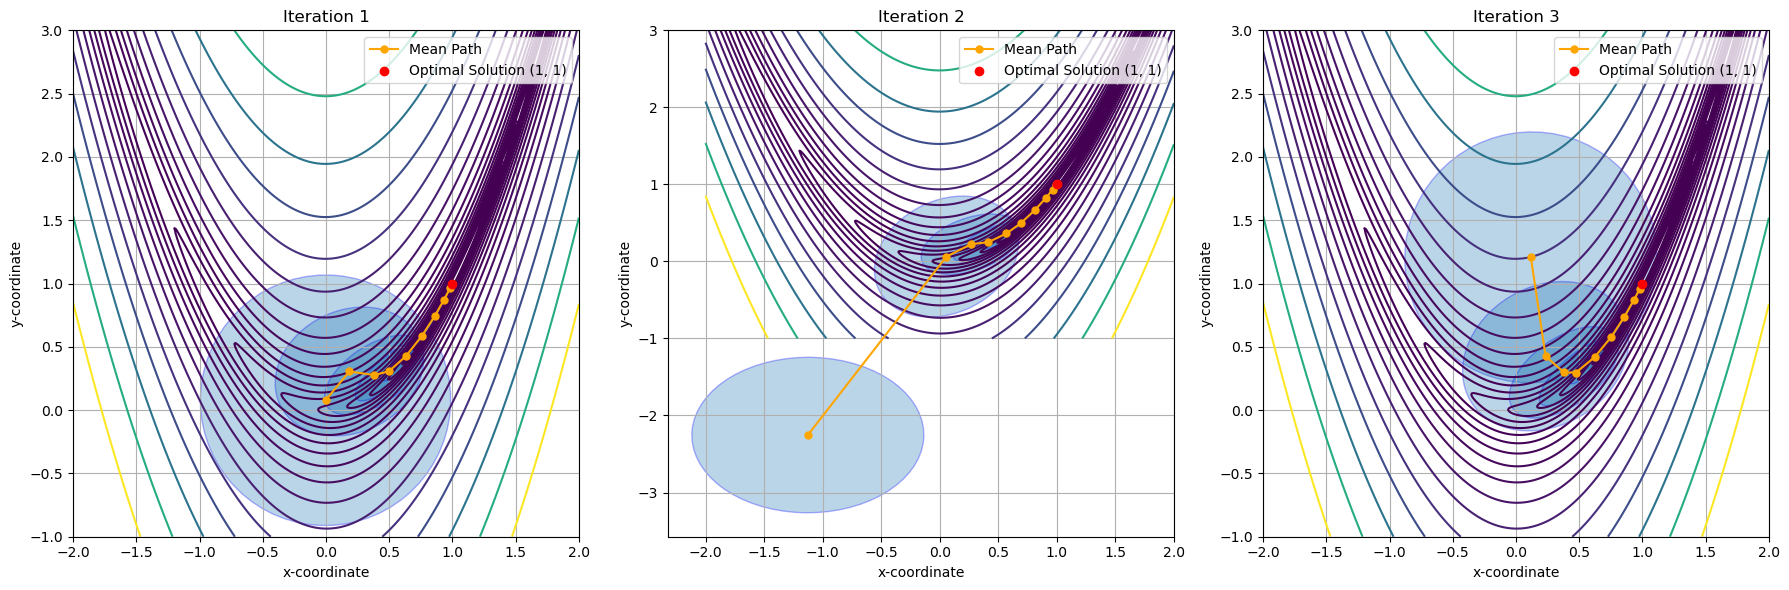

In [82]:
x_vals = np.linspace(-2, 2, 400)
y_vals = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.array([[rosenbrock([x, y]) for x, y in zip(row_x, row_y)] for row_x, row_y in zip(X, Y)])

# Create the figure with 3 subplots (side by side)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# For each of the three iterations (or runs), plot the relevant mean trajectory and covariance
for i, ax in enumerate(axes):
    # Extract the mean and covariance for this iteration
    mean_trajectory = np.array(mean_trajectories[i])
    covariance_trajectory = np.array(covariance_trajectories[i])

    # Plot the contour of the Rosenbrock function
    ax.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap='viridis')

    # Plot the mean trajectory (orange path)
    ax.plot(mean_trajectory[:, 0], mean_trajectory[:, 1], marker='o', markersize=5, color='orange', label='Mean Path')

    # Highlight the optimal solution (1, 1)
    ax.scatter([1], [1], color='red', label='Optimal Solution (1, 1)', zorder=5)

    # Add the covariance ellipse at the current iteration
    for mu, cov in zip(mean_trajectory, covariance_trajectory):
        ellipse = plot_cov_ellipse(cov, mu, nstd=1, edgecolor='blue', alpha=0.3)
        ax.add_patch(ellipse)

    # Title and labels
    ax.set_title(f"Iteration {i + 1}")
    ax.set_xlabel("x-coordinate")
    ax.set_ylabel("y-coordinate")
    ax.grid()
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


C:\Users\Vit_Chun\AppData\Local\Temp\ipykernel_18972\2245786492.py:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  z = np.random.multivariate_normal(mu, sigma, num_samples)


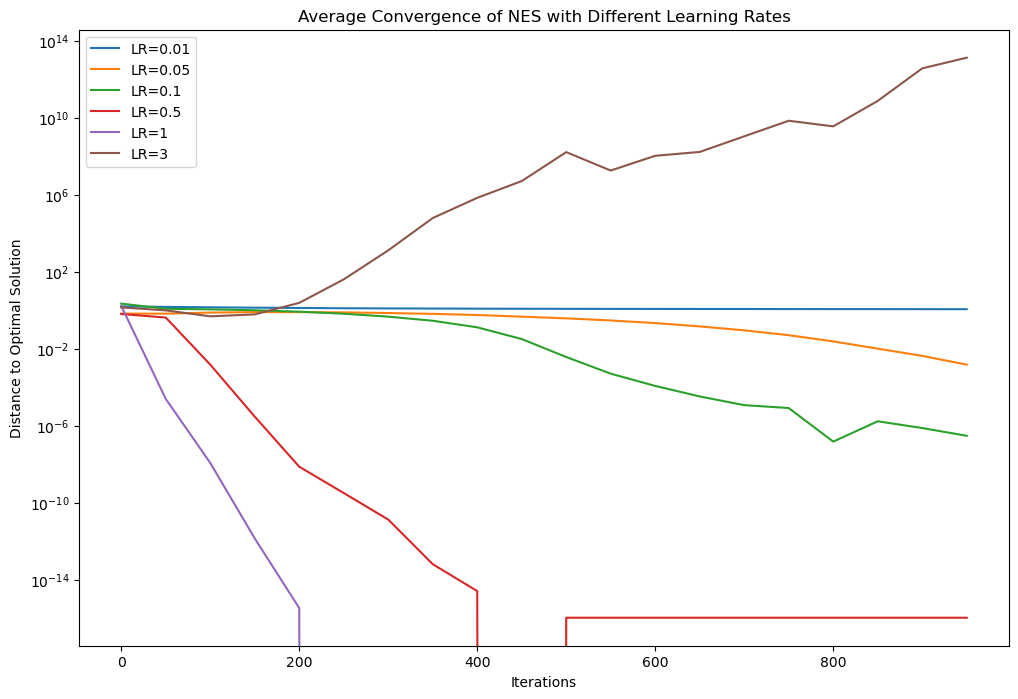

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_iterations = 1000
num_samples = 100
dimension = 2

# Define a range of learning rates to test
learning_rates = [0.01, 0.05, 0.1, 0.5, 1, 3]
all_avg_trajectories = []

# Run NES with different learning rates
for lr in learning_rates:
    mean_trajectories = []
    # Perform three runs for each learning rate
    for i in range(3):
        final_mean, mean_trajectory, _ = nes(rosenbrock, num_iterations, num_samples, dimension, lr)
        mean_trajectories.append(mean_trajectory)
    
    # Compute the average trajectory for this learning rate across all runs
    avg_trajectory = np.mean(mean_trajectories, axis=0)
    all_avg_trajectories.append(avg_trajectory)

# Plot average convergence for each learning rate
plt.figure(figsize=(12, 8))
for idx, lr in enumerate(learning_rates):
    avg_trajectory = all_avg_trajectories[idx]
    avg_trajectory_norms = [np.linalg.norm(mean - np.array([1, 1])) for mean in avg_trajectory]  # Distance to optimal solution [1, 1]
    
    # Scale x-axis by 50
    plt.plot(np.arange(len(avg_trajectory)) * 50, avg_trajectory_norms, label=f"LR={lr}")

plt.xlabel("Iterations")
plt.ylabel("Distance to Optimal Solution")
plt.title("Average Convergence of NES with Different Learning Rates")
plt.yscale('log')  # Use a log scale if convergence differences are large
plt.legend()
plt.show()


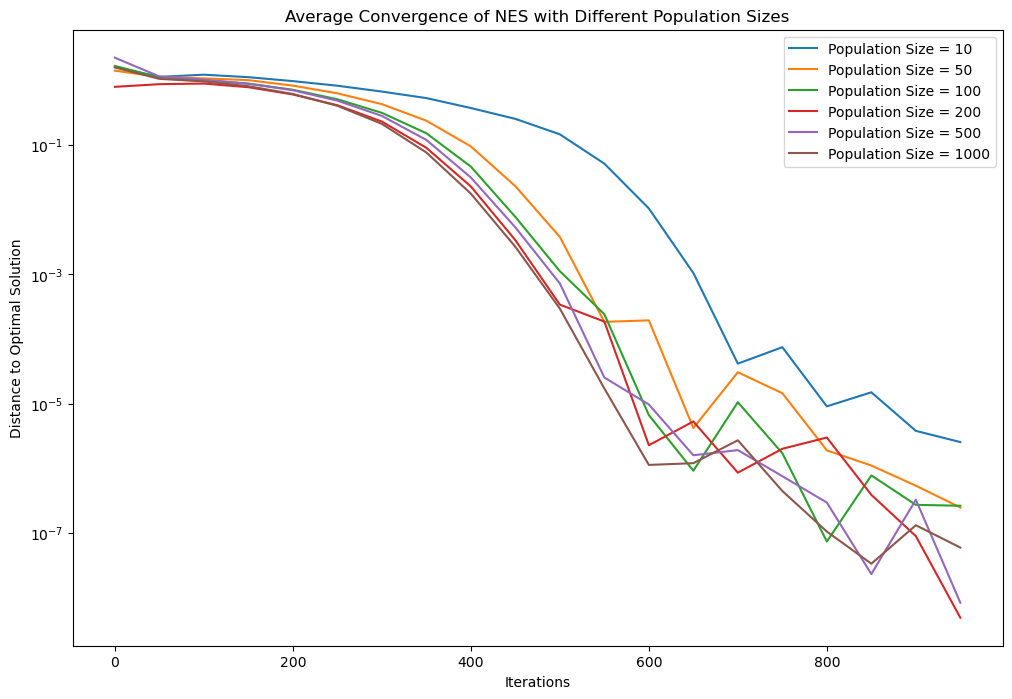

In [91]:
# Parameters
num_iterations = 1000
learning_rate = 0.1
dimension = 2
population_sizes = [10, 50, 100, 200, 500, 1000]  # Different population sizes to test

# Store results for each population size
all_avg_trajectories = []

for pop_size in population_sizes:
    mean_trajectories = []
    
    # Run NES multiple times for each population size and average the results
    for i in range(3):  # Running 3 times to get a reliable average
        _, mean_trajectory, _ = nes(rosenbrock, num_iterations, pop_size, dimension, learning_rate)
        mean_trajectories.append(mean_trajectory)
    
    # Calculate the average trajectory over the runs
    avg_trajectory = np.mean(mean_trajectories, axis=0)
    all_avg_trajectories.append(avg_trajectory)

# Plot average convergence for each population size
plt.figure(figsize=(12, 8))
for idx, pop_size in enumerate(population_sizes):
    avg_trajectory = all_avg_trajectories[idx]
    avg_trajectory_norms = [np.linalg.norm(mean - np.array([1, 1])) for mean in avg_trajectory]  # Distance to optimal solution [1, 1]
    
    # Ensure x-axis matches the length of avg_trajectory
    plt.plot(np.arange(len(avg_trajectory)) * 50, avg_trajectory_norms, label=f"Population Size = {pop_size}")

plt.xlabel("Iterations")
plt.ylabel("Distance to Optimal Solution")
plt.title("Average Convergence of NES with Different Population Sizes")
plt.yscale('log')  # Use a log scale if convergence differences are large
plt.legend()
plt.show()
